In [3]:
import polars as pl

In [4]:
df = pl.read_csv("sales_data_sample.csv",encoding='latin1')

In [5]:
df.head()

ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
i64,i64,f64,i64,f64,str,str,i64,i64,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str
10107,30,95.7,2,2871.0,"""2/24/2003 0:00""","""Shipped""",1,2,2003,"""Motorcycles""",95,"""S10_1678""","""Land of Toys Inc.""","""2125557818""","""897 Long Airport Avenue""",null,"""NYC""","""NY""","""10022""","""USA""","""NA""","""Yu""","""Kwai""","""Small"""
10121,34,81.35,5,2765.9,"""5/7/2003 0:00""","""Shipped""",2,5,2003,"""Motorcycles""",95,"""S10_1678""","""Reims Collectables""","""26.47.1555""","""59 rue de l'Abbaye""",null,"""Reims""",null,"""51100""","""France""","""EMEA""","""Henriot""","""Paul""","""Small"""
10134,41,94.74,2,3884.34,"""7/1/2003 0:00""","""Shipped""",3,7,2003,"""Motorcycles""",95,"""S10_1678""","""Lyon Souveniers""","""+33 1 46 62 7555""","""27 rue du Colonel Pierre Avia""",null,"""Paris""",null,"""75508""","""France""","""EMEA""","""Da Cunha""","""Daniel""","""Medium"""
10145,45,83.26,6,3746.7,"""8/25/2003 0:00""","""Shipped""",3,8,2003,"""Motorcycles""",95,"""S10_1678""","""Toys4GrownUps.com""","""6265557265""","""78934 Hillside Dr.""",null,"""Pasadena""","""CA""","""90003""","""USA""","""NA""","""Young""","""Julie""","""Medium"""
10159,49,100.0,14,5205.27,"""10/10/2003 0:00""","""Shipped""",4,10,2003,"""Motorcycles""",95,"""S10_1678""","""Corporate Gift Ideas Co.""","""6505551386""","""7734 Strong St.""",null,"""San Francisco""","""CA""",null,"""USA""","""NA""","""Brown""","""Julie""","""Medium"""


In [6]:
df.schema

Schema([('ORDERNUMBER', Int64),
        ('QUANTITYORDERED', Int64),
        ('PRICEEACH', Float64),
        ('ORDERLINENUMBER', Int64),
        ('SALES', Float64),
        ('ORDERDATE', String),
        ('STATUS', String),
        ('QTR_ID', Int64),
        ('MONTH_ID', Int64),
        ('YEAR_ID', Int64),
        ('PRODUCTLINE', String),
        ('MSRP', Int64),
        ('PRODUCTCODE', String),
        ('CUSTOMERNAME', String),
        ('PHONE', String),
        ('ADDRESSLINE1', String),
        ('ADDRESSLINE2', String),
        ('CITY', String),
        ('STATE', String),
        ('POSTALCODE', String),
        ('COUNTRY', String),
        ('TERRITORY', String),
        ('CONTACTLASTNAME', String),
        ('CONTACTFIRSTNAME', String),
        ('DEALSIZE', String)])

In [7]:
df_clean = df.with_columns(
           pl.col("ORDERDATE").str.to_datetime(
                format="%m/%d/%Y %H:%M", strict=True
            ).alias("ORDERDATE"),


            pl.col("STATUS").cast(pl.Categorical),
            pl.col("PRODUCTLINE").cast(pl.Categorical),
            pl.col("COUNTRY").cast(pl.Categorical),
            pl.col("DEALSIZE").cast(pl.Categorical),
            pl.col("CITY").cast(pl.Categorical)
        )

In [8]:
df_clean.schema

Schema([('ORDERNUMBER', Int64),
        ('QUANTITYORDERED', Int64),
        ('PRICEEACH', Float64),
        ('ORDERLINENUMBER', Int64),
        ('SALES', Float64),
        ('ORDERDATE', Datetime(time_unit='us', time_zone=None)),
        ('STATUS', Categorical(ordering='physical')),
        ('QTR_ID', Int64),
        ('MONTH_ID', Int64),
        ('YEAR_ID', Int64),
        ('PRODUCTLINE', Categorical(ordering='physical')),
        ('MSRP', Int64),
        ('PRODUCTCODE', String),
        ('CUSTOMERNAME', String),
        ('PHONE', String),
        ('ADDRESSLINE1', String),
        ('ADDRESSLINE2', String),
        ('CITY', Categorical(ordering='physical')),
        ('STATE', String),
        ('POSTALCODE', String),
        ('COUNTRY', Categorical(ordering='physical')),
        ('TERRITORY', String),
        ('CONTACTLASTNAME', String),
        ('CONTACTFIRSTNAME', String),
        ('DEALSIZE', Categorical(ordering='physical'))])

In [9]:
null_counts = df_clean.null_count().transpose(include_header=True)
null_counts = null_counts.rename({"column": "column", "column_0": "null_count"})
print(null_counts.filter(pl.col("null_count") > 0))

shape: (3, 2)
┌──────────────┬────────────┐
│ column       ┆ null_count │
│ ---          ┆ ---        │
│ str          ┆ u32        │
╞══════════════╪════════════╡
│ ADDRESSLINE2 ┆ 2521       │
│ STATE        ┆ 1486       │
│ POSTALCODE   ┆ 76         │
└──────────────┴────────────┘


In [10]:
print(df_clean.get_column("STATUS").value_counts().sort("count", descending=True))

shape: (6, 2)
┌────────────┬───────┐
│ STATUS     ┆ count │
│ ---        ┆ ---   │
│ cat        ┆ u32   │
╞════════════╪═══════╡
│ Shipped    ┆ 2617  │
│ Cancelled  ┆ 60    │
│ Resolved   ┆ 47    │
│ On Hold    ┆ 44    │
│ In Process ┆ 41    │
│ Disputed   ┆ 14    │
└────────────┴───────┘


In [11]:
df_validation = df_clean.with_columns(
            (pl.col("QUANTITYORDERED") * pl.col("PRICEEACH") - pl.col("SALES")).abs().alias("SALES_DIFFERENCE")
        )

print(df_validation.select(pl.col("SALES_DIFFERENCE")).describe())

shape: (9, 2)
┌────────────┬──────────────────┐
│ statistic  ┆ SALES_DIFFERENCE │
│ ---        ┆ ---              │
│ str        ┆ f64              │
╞════════════╪══════════════════╡
│ count      ┆ 2823.0           │
│ null_count ┆ 0.0              │
│ mean       ┆ 616.982664       │
│ std        ┆ 1047.728887      │
│ min        ┆ 0.0              │
│ 25%        ┆ 0.0              │
│ 50%        ┆ 4.5475e-13       │
│ 75%        ┆ 925.76           │
│ max        ┆ 7536.5           │
└────────────┴──────────────────┘


In [12]:
print(f"Temizlenmiş Veri Boyutu (Önce): {df_clean.shape}")

# --- 1. Özellik Mühendisliği ve Sütun Kaldırma ---
df_eda = df_clean.with_columns(

# 1.a: SALES farkını ve bayrağını (flag) oluşturalım
# 0.01'den büyük farkları 'gerçek' fark olarak kabul edelim (kayan nokta hatalarını tolere etmek için)
(pl.col("QUANTITYORDERED") * pl.col("PRICEEACH") - pl.col("SALES")).abs().alias("SALES_DIFFERENCE"),

((pl.col("QUANTITYORDERED") * pl.col("PRICEEACH") - pl.col("SALES")).abs() > 0.01).alias("IS_DISCREPANT"),

# 1.b: Tarih sütunundan yeni özellikler türetme

pl.col("ORDERDATE").dt.year().alias("ORDER_YEAR"),
pl.col("ORDERDATE").dt.month().alias("ORDER_MONTH"),
pl.col("ORDERDATE").dt.weekday().alias("ORDER_WEEKDAY"),
pl.col("ORDERDATE").dt.quarter().alias("ORDER_QUARTER")

).drop(

        "ADDRESSLINE2",
        "PHONE",
        "CONTACTLASTNAME",
        "CONTACTFIRSTNAME"
    )

print(f"Yeni Veri Boyutu (Sonra): {df_eda.shape}")
print("\n--- Yeni Türetilmiş Sütunlarla İlk 5 Satır ---")
print(df_eda.head())

# --- 2. Kritik Bulgu Araştırması: Bu Fark Neden Kaynaklanıyor? ---
print("\n--- 'SALES_DIFFERENCE' Araştırması ---")


print("\nFarklı ('IS_DISCREPANT') Satır Sayıları:")
print(df_eda.get_column("IS_DISCREPANT").value_counts())


print("\n'DEALSIZE' Sütununun Farklı Satırlardaki Dağılımı:")

discrepant_deals = df_eda.filter(
        pl.col("IS_DISCREPANT") == True
    ).get_column("DEALSIZE").value_counts().sort("count", descending=True)

print(discrepant_deals)

print("\nGenel 'DEALSIZE' Dağılımı (Karşılaştırma için):")
all_deals = df_eda.get_column("DEALSIZE").value_counts().sort("count", descending=True)
print(all_deals)

Temizlenmiş Veri Boyutu (Önce): (2823, 25)
Yeni Veri Boyutu (Sonra): (2823, 27)

--- Yeni Türetilmiş Sütunlarla İlk 5 Satır ---
shape: (5, 27)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ORDERNUMB ┆ QUANTITYO ┆ PRICEEACH ┆ ORDERLINE ┆ … ┆ ORDER_YEA ┆ ORDER_MON ┆ ORDER_WEE ┆ ORDER_QU │
│ ER        ┆ RDERED    ┆ ---       ┆ NUMBER    ┆   ┆ R         ┆ TH        ┆ KDAY      ┆ ARTER    │
│ ---       ┆ ---       ┆ f64       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ i64       ┆ i64       ┆           ┆ i64       ┆   ┆ i32       ┆ i8        ┆ i8        ┆ i8       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 10107     ┆ 30        ┆ 95.7      ┆ 2         ┆ … ┆ 2003      ┆ 2         ┆ 1         ┆ 1        │
│ 10121     ┆ 34        ┆ 81.35     ┆ 5         ┆ … ┆ 2003      ┆ 5         ┆ 3         ┆ 2        │
│ 10134     ┆ 41        ┆ 94.74     ┆ 2         ┆

In [13]:
# Yeni bir 'CALCULATED_SALES' (Hesaplanan Satışlar) sütunu oluşturalım
df_final = df_eda.with_columns(
(pl.col("QUANTITYORDERED") * pl.col("PRICEEACH")).alias("CALCULATED_SALES")
    )

# İndirim sütunlarını oluşturalım
df_final = df_final.with_columns(
# Farkı 'DISCOUNT_AMOUNT' olarak yeniden adlandırıyoruz
(pl.col("CALCULATED_SALES") - pl.col("SALES")).alias("DISCOUNT_AMOUNT"),

# İndirim Yüzdesi (0'a bölme hatasını önlemek için 'when/then/otherwise' kullanıyoruz)
pl.when(pl.col("CALCULATED_SALES") > 0)
          .then( (pl.col("CALCULATED_SALES") - pl.col("SALES")) / pl.col("CALCULATED_SALES") )
          .otherwise(0)
          .alias("DISCOUNT_PERCENTAGE")
    )

print("--- İndirim Sütunları Eklendi ---")
print(df_final.select([
        "SALES",
        "CALCULATED_SALES",
        "DISCOUNT_AMOUNT",
        "DISCOUNT_PERCENTAGE",
        "DEALSIZE"
    ]).head())

# --- 2. ANA KEŞİFÇİ VERİ ANALİZİ (EDA) ---
# Artık 'group_by' ve 'agg' ile özet tablolar oluşturabiliriz.

# Soru 1: Yıllara ve Çeyreklere Göre Toplam Satış (SALES) Trendi
print("\n--- Soru 1: Yıllara Göre Toplam Satış (Revenue) ---")
sales_by_year = df_final.group_by("ORDER_YEAR").agg(
        pl.sum("SALES").alias("TOTAL_SALES")
    ).sort("ORDER_YEAR")
print(sales_by_year)

    # Soru 2: En Çok Satan (Ciro Bazlı) Ürün Grupları (PRODUCTLINE)
print("\n--- Soru 2: En Çok Satan Ürün Grupları ---")
sales_by_product = df_final.group_by("PRODUCTLINE").agg(
        pl.sum("SALES").alias("TOTAL_SALES")
    ).sort("TOTAL_SALES", descending=True)
print(sales_by_product)

# Soru 3: En Çok Ciro Getiren 10 Ülke (COUNTRY)
print("\n--- Soru 3: En Çok Ciro Getiren 10 Ülke ---")
sales_by_country = df_final.group_by("COUNTRY").agg(
    pl.sum("SALES").alias("TOTAL_SALES")
    ).sort("TOTAL_SALES", descending=True).head(10)
print(sales_by_country)

# Soru 4: 'DEALSIZE'a Göre Ortalama İndirim Yüzdesi
print("\n--- Soru 4: Anlaşma Büyüklüğüne Göre Ortalama İndirim Yüzdesi ---")
discount_by_dealsize = df_final.group_by("DEALSIZE").agg(
        pl.mean("DISCOUNT_PERCENTAGE").alias("AVG_DISCOUNT_PERC")
    ).sort("AVG_DISCOUNT_PERC", descending=True)
print(discount_by_dealsize)

--- İndirim Sütunları Eklendi ---
shape: (5, 5)
┌─────────┬──────────────────┬─────────────────┬─────────────────────┬──────────┐
│ SALES   ┆ CALCULATED_SALES ┆ DISCOUNT_AMOUNT ┆ DISCOUNT_PERCENTAGE ┆ DEALSIZE │
│ ---     ┆ ---              ┆ ---             ┆ ---                 ┆ ---      │
│ f64     ┆ f64              ┆ f64             ┆ f64                 ┆ cat      │
╞═════════╪══════════════════╪═════════════════╪═════════════════════╪══════════╡
│ 2871.0  ┆ 2871.0           ┆ 0.0             ┆ 0.0                 ┆ Small    │
│ 2765.9  ┆ 2765.9           ┆ -4.5475e-13     ┆ -1.6441e-16         ┆ Small    │
│ 3884.34 ┆ 3884.34          ┆ -4.5475e-13     ┆ -1.1707e-16         ┆ Medium   │
│ 3746.7  ┆ 3746.7           ┆ 4.5475e-13      ┆ 1.2137e-16          ┆ Medium   │
│ 5205.27 ┆ 4900.0           ┆ -305.27         ┆ -0.0623             ┆ Medium   │
└─────────┴──────────────────┴─────────────────┴─────────────────────┴──────────┘

--- Soru 1: Yıllara Göre Toplam Satış (Revenue) -

/tmp/ipython-input-353927336.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


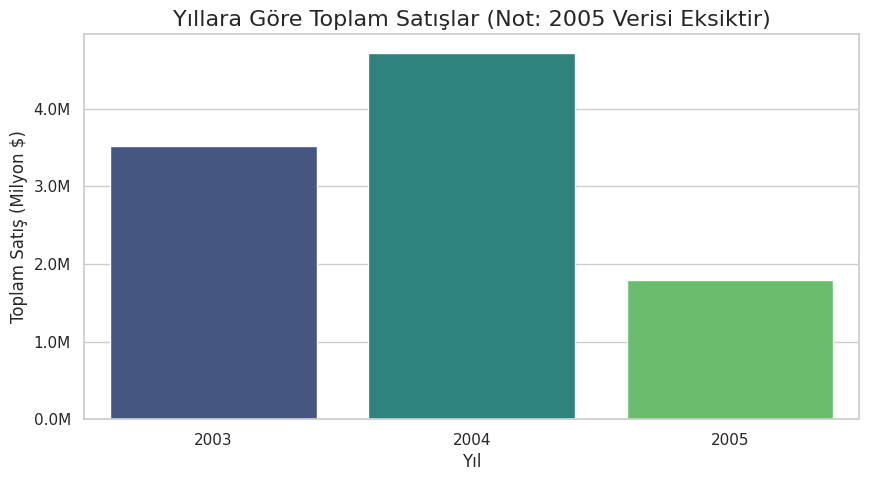

/tmp/ipython-input-353927336.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


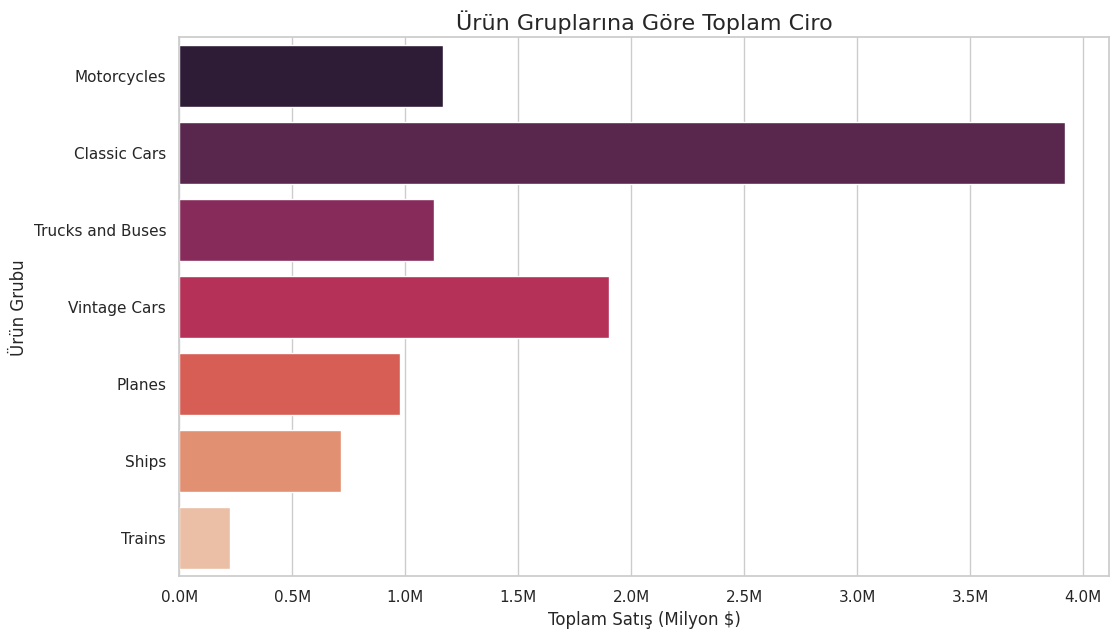

/tmp/ipython-input-353927336.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


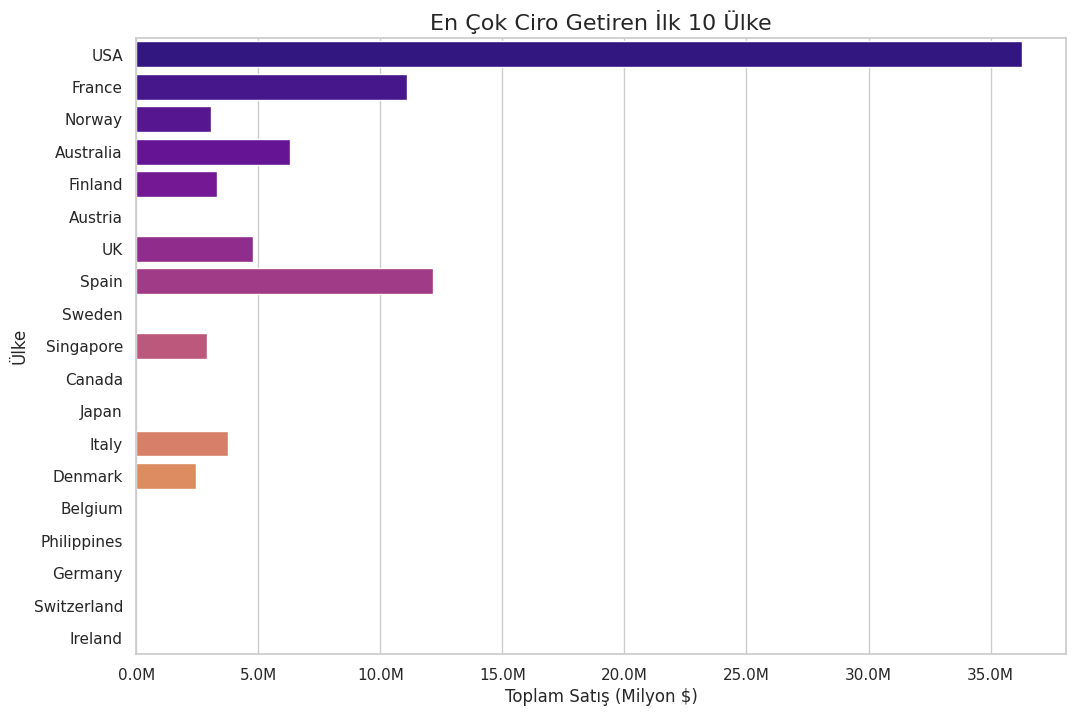

/tmp/ipython-input-353927336.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


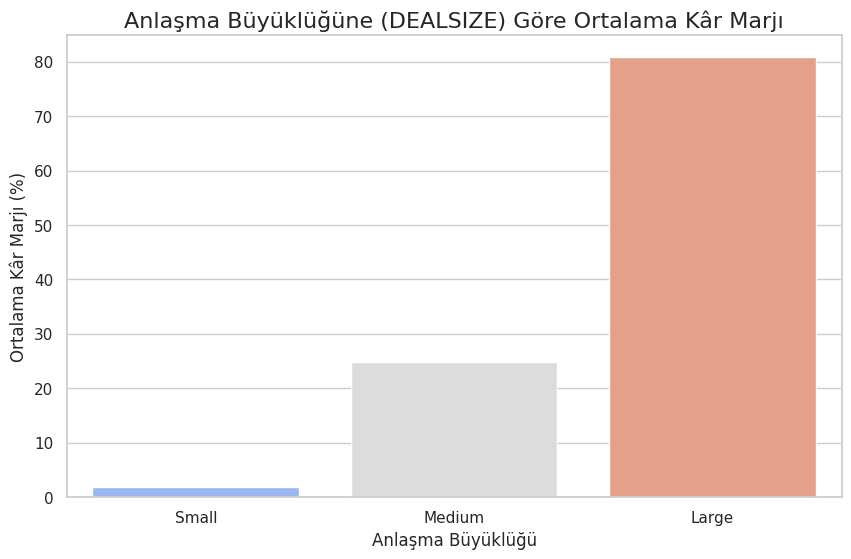

In [14]:
# Gerekli kütüphaneleri import edelim
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

# Seaborn için varsayılan bir tema belirleyelim (daha şık görünür)
sns.set_theme(style="whitegrid")

# (Önceki adımda bu DataFrame'leri oluşturduğumuzu varsayıyoruz:
# sales_by_year, sales_by_product, sales_by_country, discount_by_dealsize)

# --- 1. GÖRSEL: Yıllara Göre Satış (Revenue by Year) ---
if 'sales_by_year' in globals():
    plt.figure(figsize=(10, 5)) # Grafiğin boyutunu belirle

    # Seaborn ile çubuk grafik oluştur
    sns.barplot(
        data=sales_by_year.to_pandas(), # Polars -> Pandas
        x="ORDER_YEAR",
        y="TOTAL_SALES",
        palette="viridis" # Renk paleti
    )

    # Grafiğe etiketler ve başlık ekle
    plt.title("Yıllara Göre Toplam Satışlar (Not: 2005 Verisi Eksiktir)", fontsize=16)
    plt.xlabel("Yıl", fontsize=12)
    plt.ylabel("Toplam Satış (Milyon $)", fontsize=12)

    # Y eksenini daha okunaklı hale getir (örn: 4.000.000 yerine 4M)
    formatter = plt.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.show() # Grafiği göster

# --- 2. GÖRSEL: En Çok Ciro Getiren Ürün Grupları ---
if 'sales_by_product' in globals():
    plt.figure(figsize=(12, 7))

    # Yatay çubuk grafik (kategori isimleri uzunsa en iyisi budur)
    sns.barplot(
        data=sales_by_product.to_pandas(),
        x="TOTAL_SALES",
        y="PRODUCTLINE", # x ve y'nin yeri değişti
        palette="rocket"
    )

    plt.title("Ürün Gruplarına Göre Toplam Ciro", fontsize=16)
    plt.xlabel("Toplam Satış (Milyon $)", fontsize=12)
    plt.ylabel("Ürün Grubu", fontsize=12)

    # X eksenini okunaklı hale getir
    formatter = plt.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.show()

# --- 3. GÖRSEL: En Çok Ciro Getiren 10 Ülke ---
if 'sales_by_country' in globals():
    plt.figure(figsize=(12, 8))

    sns.barplot(
        data=sales_by_country.to_pandas(),
        x="TOTAL_SALES",
        y="COUNTRY",
        palette="plasma"
    )

    plt.title("En Çok Ciro Getiren İlk 10 Ülke", fontsize=16)
    plt.xlabel("Toplam Satış (Milyon $)", fontsize=12)
    plt.ylabel("Ülke", fontsize=12)

    formatter = plt.FuncFormatter(lambda x, pos: f'{x/1_00_000:.1f}M')
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.show()

# --- 4. GÖRSEL: (EN ÖNEMLİ BULGU) Kâr Marjı Analizi ---
if 'discount_by_dealsize' in globals():

    # ÖNEMLİ: Yüzdeleri grafikte daha anlamlı göstermek için
    # negatif değeri pozitife çevirip 100 ile çarpıyoruz.
    # Örn: -0.80 -> 80% Kâr Marjı

    plot_data_dealsize = discount_by_dealsize.with_columns(
        (pl.col("AVG_DISCOUNT_PERC") * -100).alias("AVG_MARKUP_PERC")
    ).sort("AVG_MARKUP_PERC", descending=False) # Small -> Medium -> Large

    plt.figure(figsize=(10, 6))

    sns.barplot(
        data=plot_data_dealsize.to_pandas(),
        x="DEALSIZE",
        y="AVG_MARKUP_PERC",
        palette="coolwarm"
    )

    plt.title("Anlaşma Büyüklüğüne (DEALSIZE) Göre Ortalama Kâr Marjı", fontsize=16)
    plt.xlabel("Anlaşma Büyüklüğü", fontsize=12)
    plt.ylabel("Ortalama Kâr Marjı (%)", fontsize=12)

    plt.show()

else:
    print("Hata: Özet DataFrame'ler bulunamadı. Lütfen 4. Adımı çalıştırın.")